# **FGV EESP**

- ## VAR e VECM - Expectativa de Inflação
---



### **Bibliotecas**

In [ ]:
# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

# Função tidy()
install.packages("broom")

In [ ]:
library(broom)
library(dplyr)
library(ggplot2)
library(httr)
library(lubridate)
library(readxl)
library(tsDyn)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [3]:
# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/public_data.xlsx"

# Download do arquivo
download.file(file_path, "public_data.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_public_data <- as.data.frame(read_excel("public_data.xlsx"))

# Converter year e month_name
df_public_data <- df_public_data %>%
  mutate(year = as.numeric(year),  # Converter year para numérico
         month_name = factor(month_name, levels = month.abb, ordered = TRUE))  # Converter month_name para um fator ordenado

# Converter month_date
df_public_data$month_date <- ymd(df_public_data$month_date)  # Converter month_date para formato Date

# Lista de variáveis para transformar em séries temporais
vars_to_convert <- c("month", "market_inflation_expectation", "consumer_inflation_expectation", "inflation_target", "inflation_target_lower_bound", "inflation_target_upper_bound", "inflation_target_wtd_avg", "inflation_target_lower_bound_wtd_avg", "inflation_target_upper_bound_wtd_avg", "ipca", "selic", "selic_deflated", "minimum_wage_increase", "minimum_wage_increase_deflated", "income_increase", "income_increase_deflated", "household_income_deflated", "household_income_deflated_trend", "household_income_deflated_trend_diff", "real_exchange_rate", "real_exchange_rate_trend", "real_exchange_rate_trend_diff", "pib", "primary_fiscal_result", "primary_fiscal_result_pct_pib", "ipca_lag", "selic_deflated_lag", "primary_fiscal_result_pct_pib_lag", "real_exchange_rate_trend_diff_lag", "household_income_deflated_trend_diff_lag")

# Loop para transformar as variáveis em séries temporais
for (var in vars_to_convert) {
  df_public_data[[var]] <- ts(df_public_data[[var]], start = c(2006, 1), frequency = 12)
}

In [4]:
str(df_public_data)

'data.frame':	210 obs. of  33 variables:
 $ year                                    : num  2006 2006 2006 2006 2006 ...
 $ month_name                              : Ord.factor w/ 12 levels "Jan"<"Feb"<"Mar"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ month_date                              : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                                   : Time-Series  from 2006 to 2023: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation            : Time-Series  from 2006 to 2023: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation          : Time-Series  from 2006 to 2023: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ inflation_target                        : Time-Series  from 2006 to 2023: 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 ...
 $ inflation_target_lower_bound            : Time-Series  from 2006 to 2023: 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 2.5 ...
 $ inflation_target_upper_bound            : Time-Series  from 2006 to 2023: 6

### **Modelo VAR**

In [5]:
# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca_lag")]

In [6]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2     12 


In [7]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "none")

tidy(var_model)

group,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_inflation_expectation,market_inflation_expectation.l1,1.24517905,0.06901364,18.042507,3.946365e-44
market_inflation_expectation,ipca_lag.l1,0.06357489,0.02884425,2.204075,2.863744e-02
market_inflation_expectation,market_inflation_expectation.l2,-0.25505612,0.06897780,-3.697655,2.796898e-04
market_inflation_expectation,ipca_lag.l2,-0.05623095,0.02894128,-1.942933,5.340048e-02
ipca_lag,market_inflation_expectation.l1,1.24517905,0.06901364,18.042507,3.946365e-44
ipca_lag,ipca_lag.l1,0.06357489,0.02884425,2.204075,2.863744e-02
ipca_lag,market_inflation_expectation.l2,-0.25505612,0.06897780,-3.697655,2.796898e-04
ipca_lag,ipca_lag.l2,-0.05623095,0.02894128,-1.942933,5.340048e-02


In [8]:
summary(var_model)


VAR Estimation Results:
Endogenous variables: market_inflation_expectation, ipca_lag 
Deterministic variables: none 
Sample size: 208 
Log Likelihood: -7.103 
Roots of the characteristic polynomial:
0.9978 0.8784 0.7054 0.1558
Call:
VAR(y = var_model_variables, p = 2, type = "none")


Estimation results for equation market_inflation_expectation: 
market_inflation_expectation = market_inflation_expectation.l1 + ipca_lag.l1 + market_inflation_expectation.l2 + ipca_lag.l2 

                                Estimate Std. Error t value Pr(>|t|)    
market_inflation_expectation.l1  1.24518    0.06901  18.043  < 2e-16 ***
ipca_lag.l1                      0.06357    0.02884   2.204  0.02864 *  
market_inflation_expectation.l2 -0.25506    0.06898  -3.698  0.00028 ***
ipca_lag.l2                     -0.05623    0.02894  -1.943  0.05340 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.1825 on 204 degrees of freedom
Multiple R-Squared: 0.9987,	Adj

In [9]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 106, df = 40, p-value = 6.997e-08



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 106, df = 40, p-value = 6.997e-08



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [10]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 195.25, df = 108, p-value = 5.592e-07



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 195.25, df = 108, p-value = 5.592e-07



**Resultado**

- Como o p-value é **menor** que um nível de significância de 5%, não se pode afirmar que o modelo não possui heteroscedasticidade

In [11]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 50.651, df = 4, p-value = 2.64e-10


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 8.546, df = 2, p-value = 0.01394


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 42.105, df = 2, p-value = 7.194e-10




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 50.651, df = 4, p-value = 2.64e-10


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 8.546, df = 2, p-value = 0.01394


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 42.105, df = 2, p-value = 7.194e-10




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

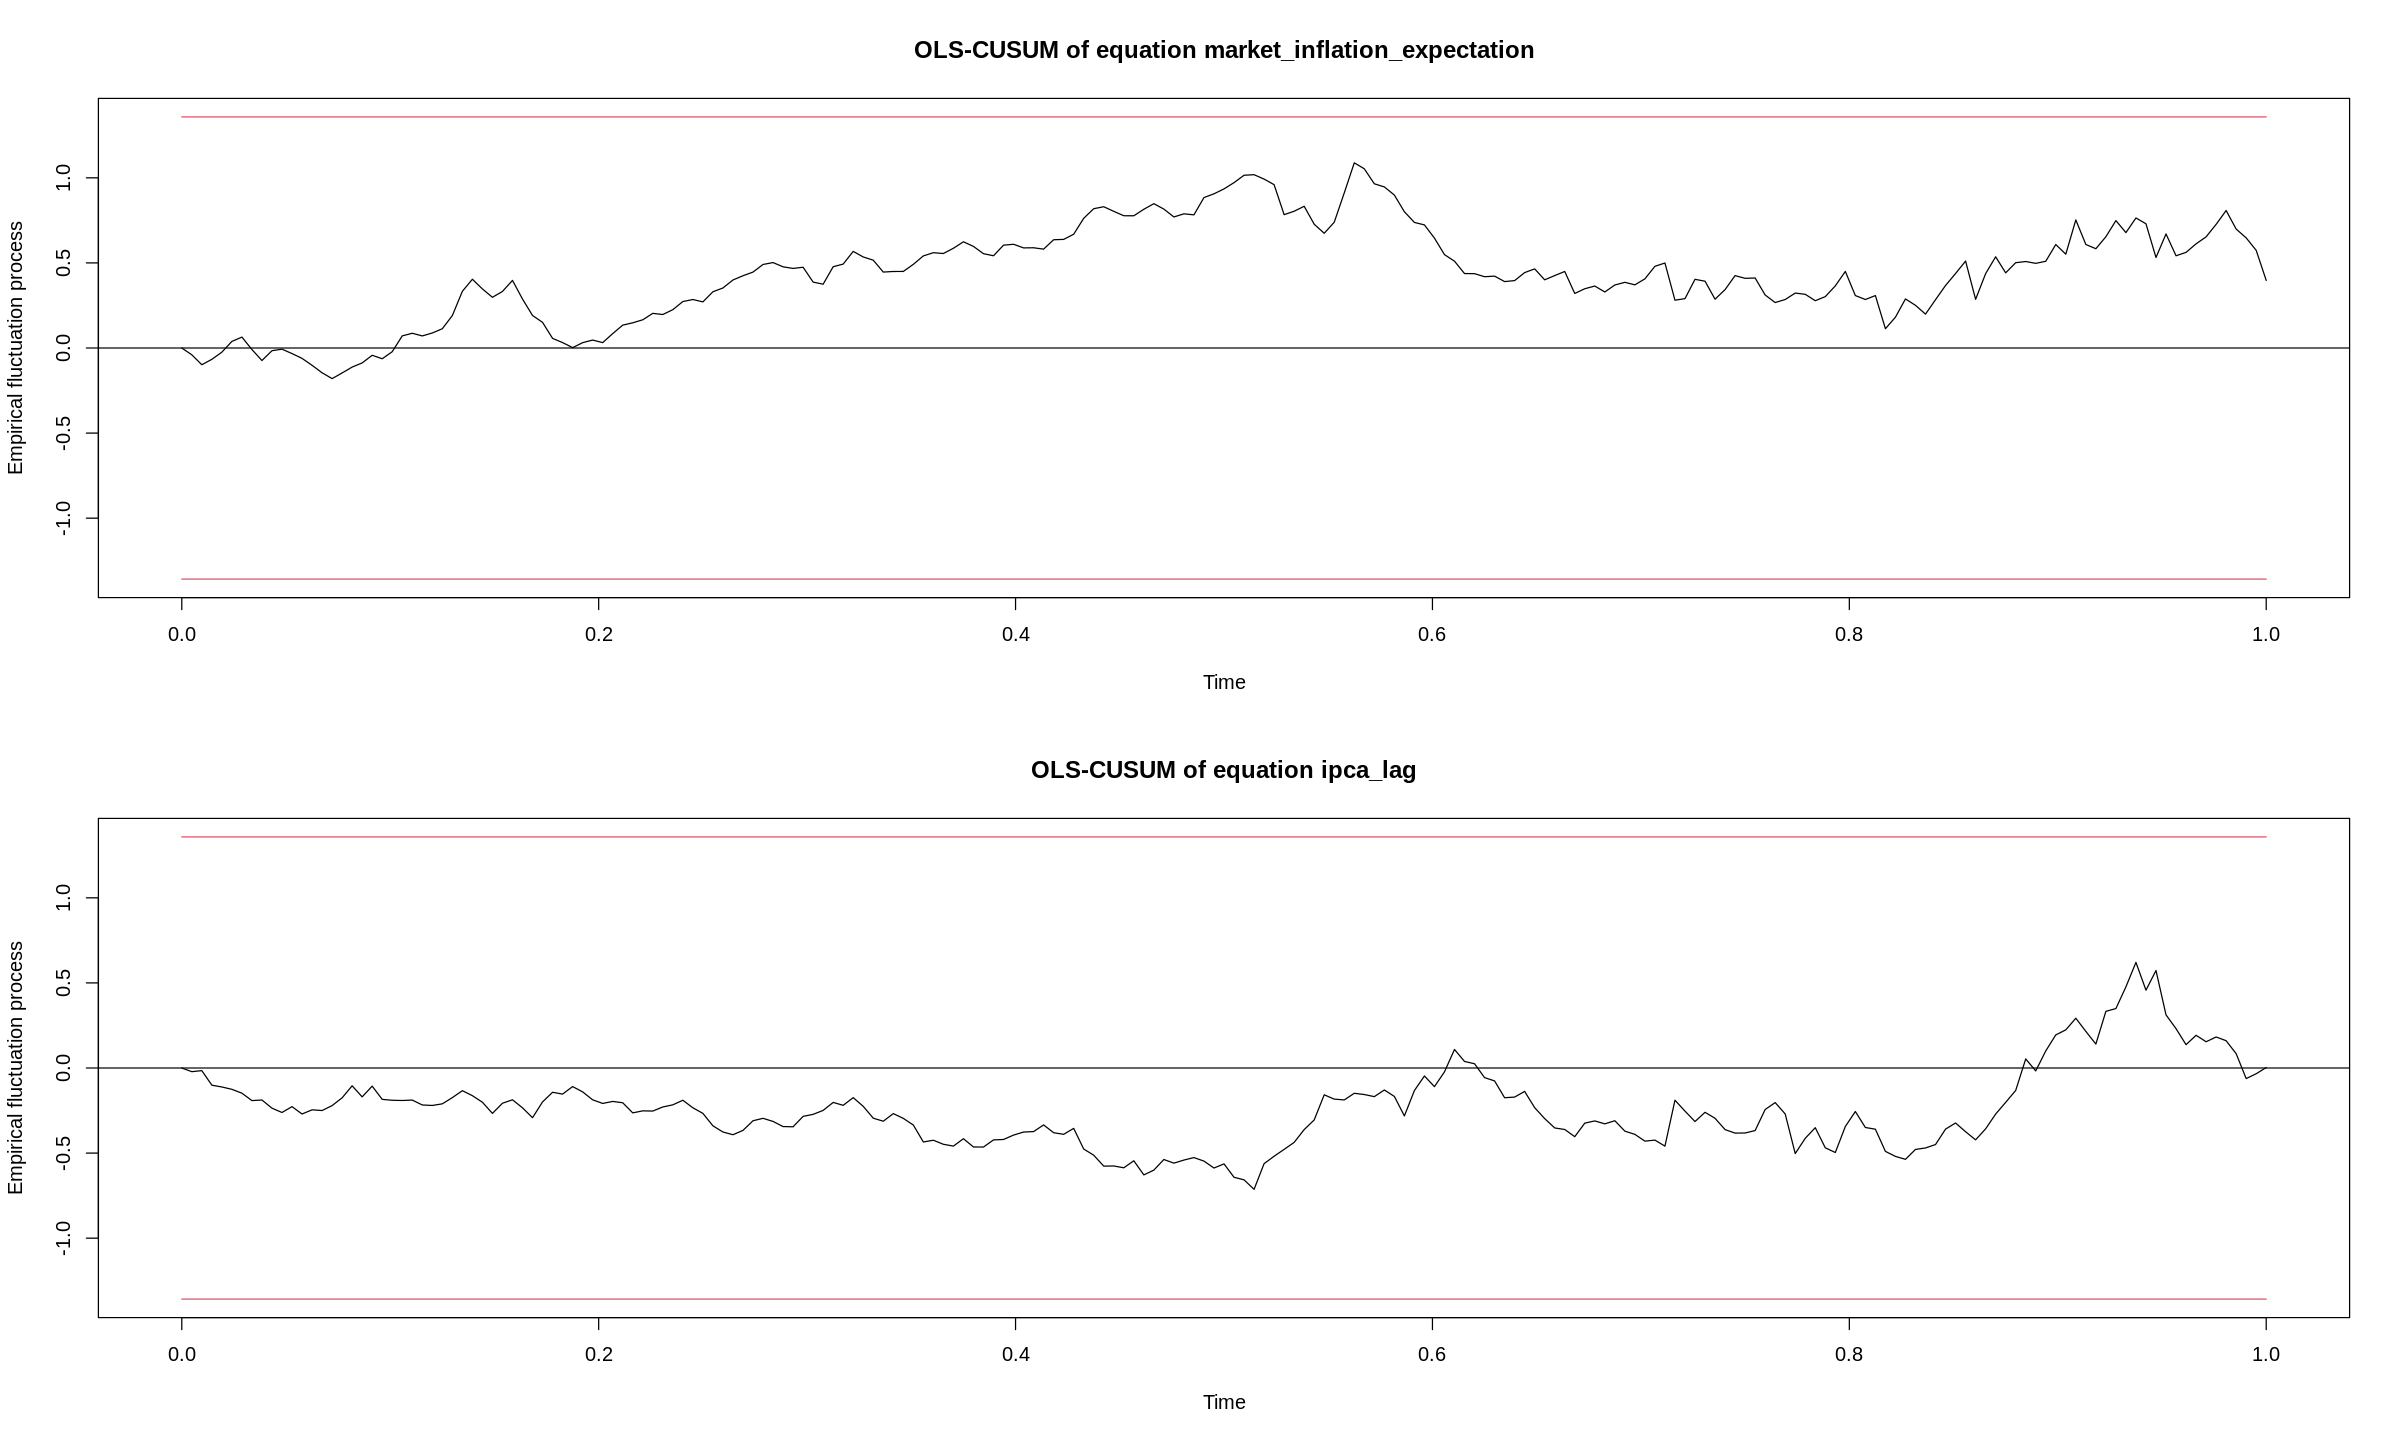

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 12)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, com exceção da variável relacionada ao resultado fiscal, pode-se afirmar que não há quebra estrutural nos resíduos

In [13]:
# Granger Causality
granger_consumer_expectation <- causality(var_model, cause = "ipca_lag")

print(granger_consumer_expectation)

$Granger

	Granger causality H0: ipca_lag do not Granger-cause
	market_inflation_expectation

data:  VAR object var_model
F-Test = 2.6621, df1 = 2, df2 = 408, p-value = 0.07101


$Instant

	H0: No instantaneous causality between: ipca_lag and
	market_inflation_expectation

data:  VAR object var_model
Chi-squared = 0.23597, df = 1, p-value = 0.6271




**Resultado**

- Como o p-valor é maior que um nível de significância de 5%, não se pode rejeitar a hipótese nula do teste de Granger e afirmar que IPCA causa, no sentido de Granger, variação na expectativa de inflação do mercado

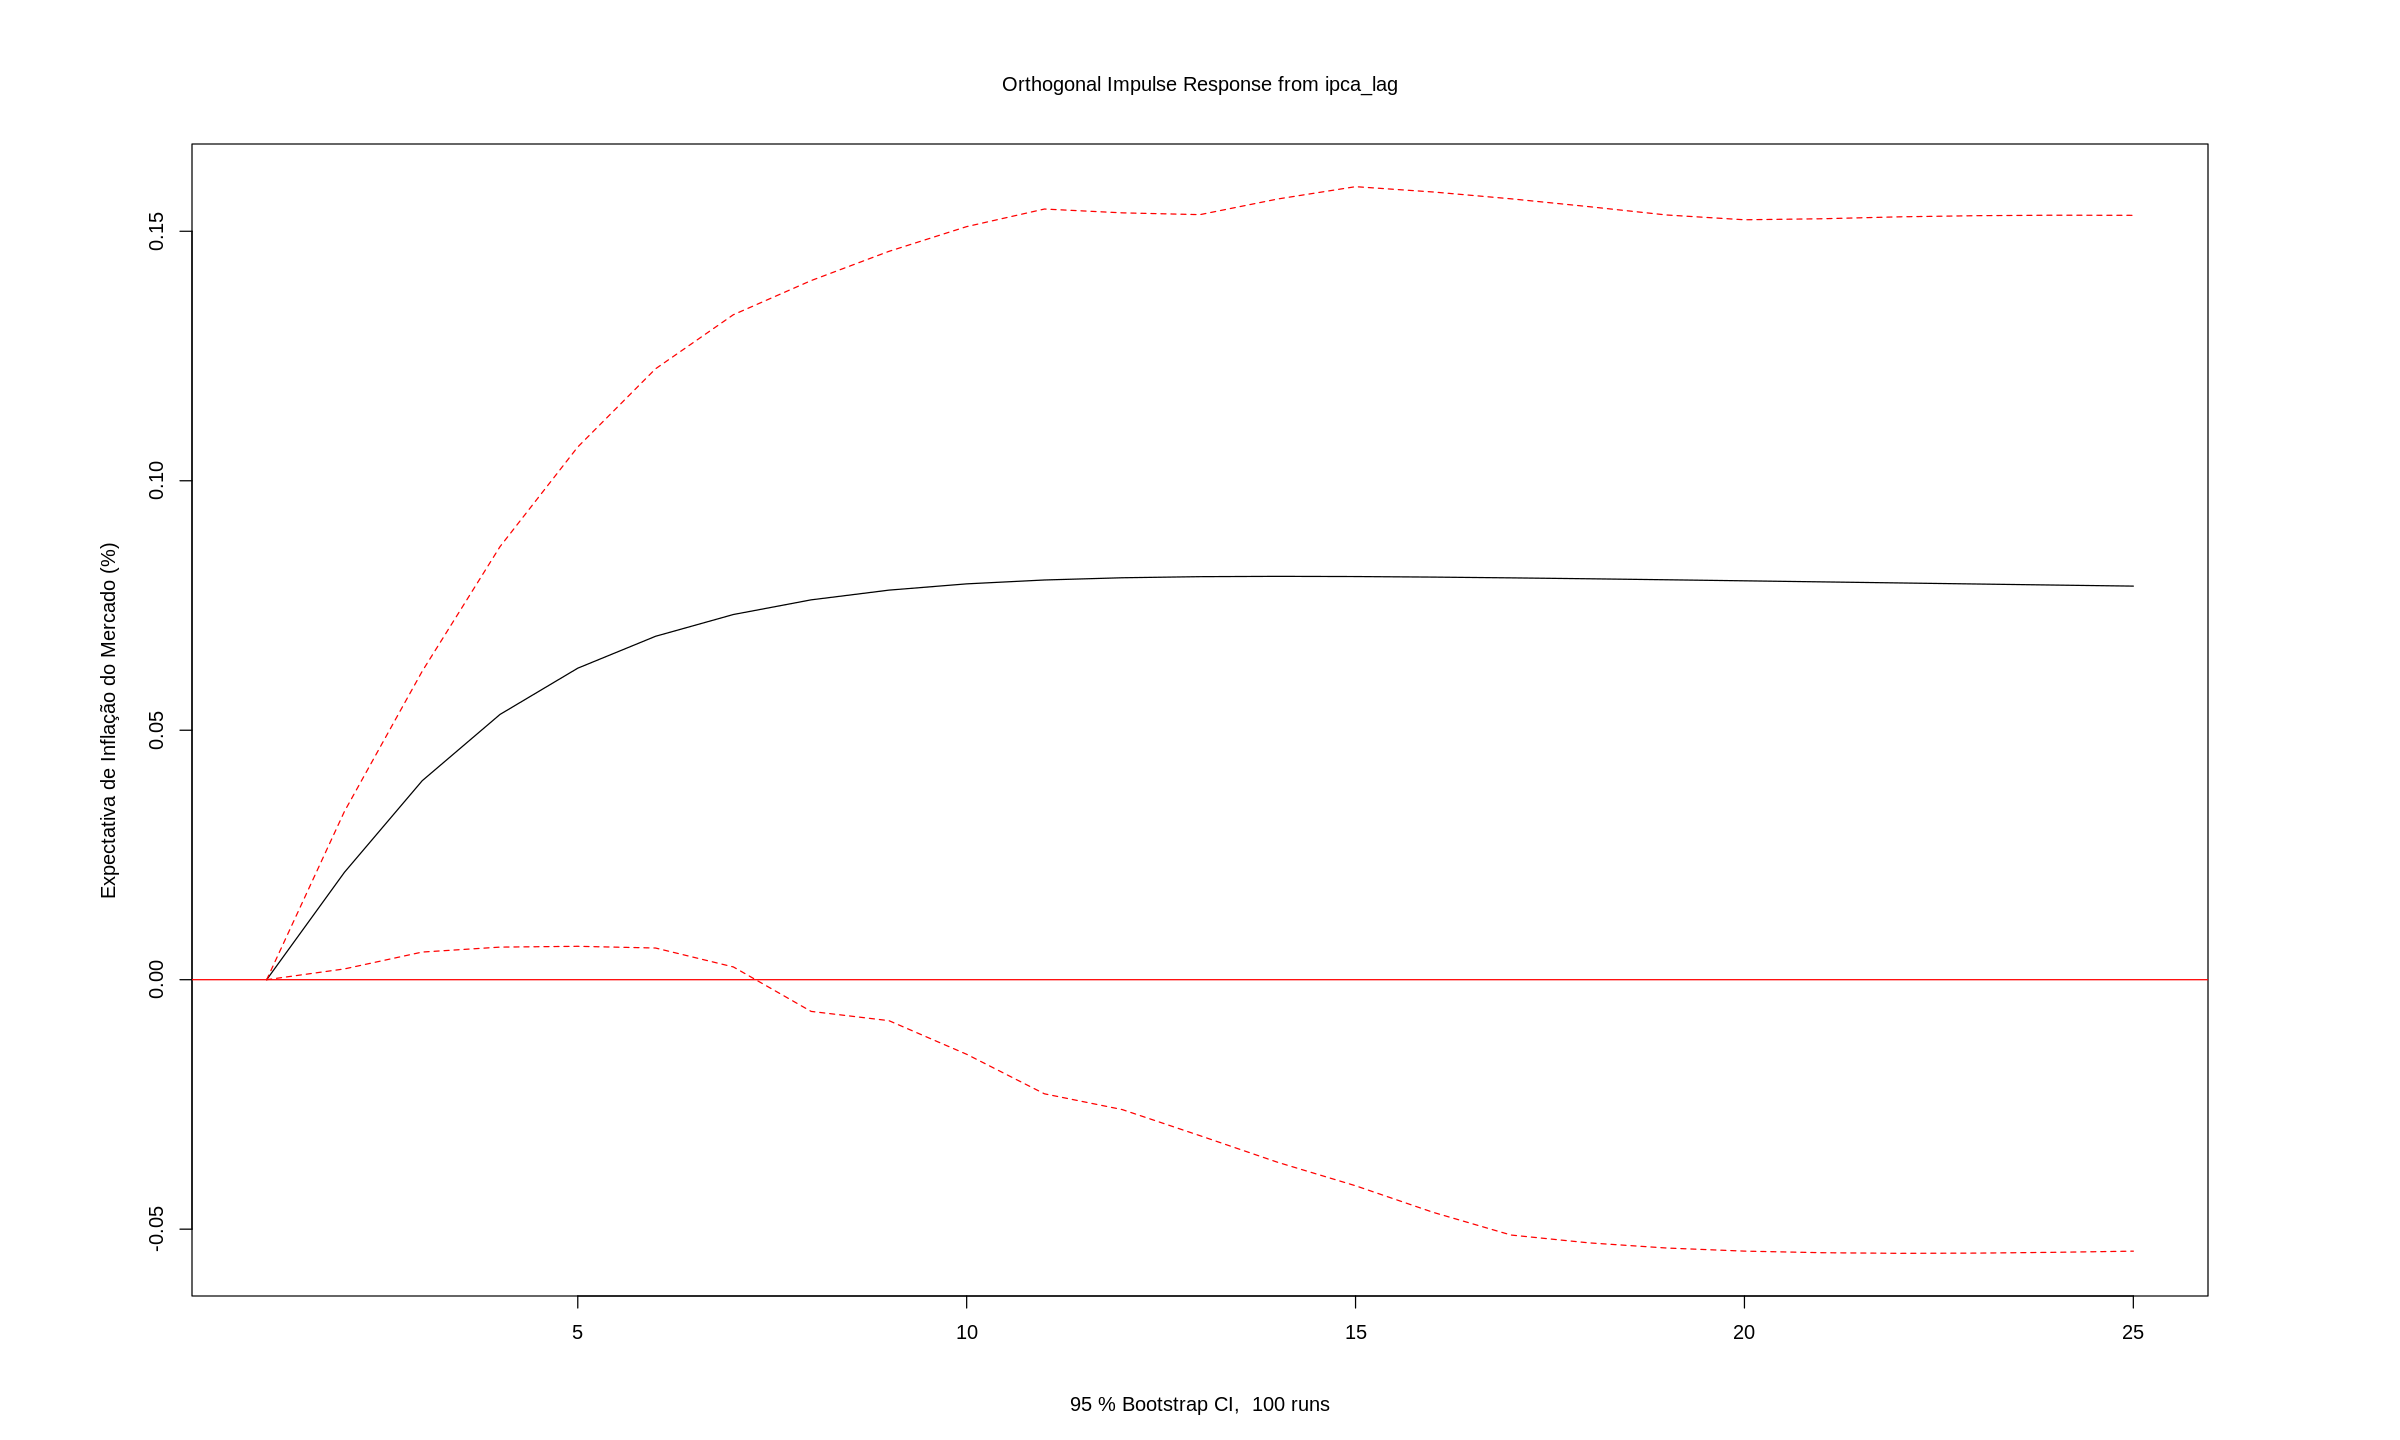

In [15]:
# Impulse Response Function
market_expectation_impulse = irf(var_model, impulse = "ipca_lag", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)")

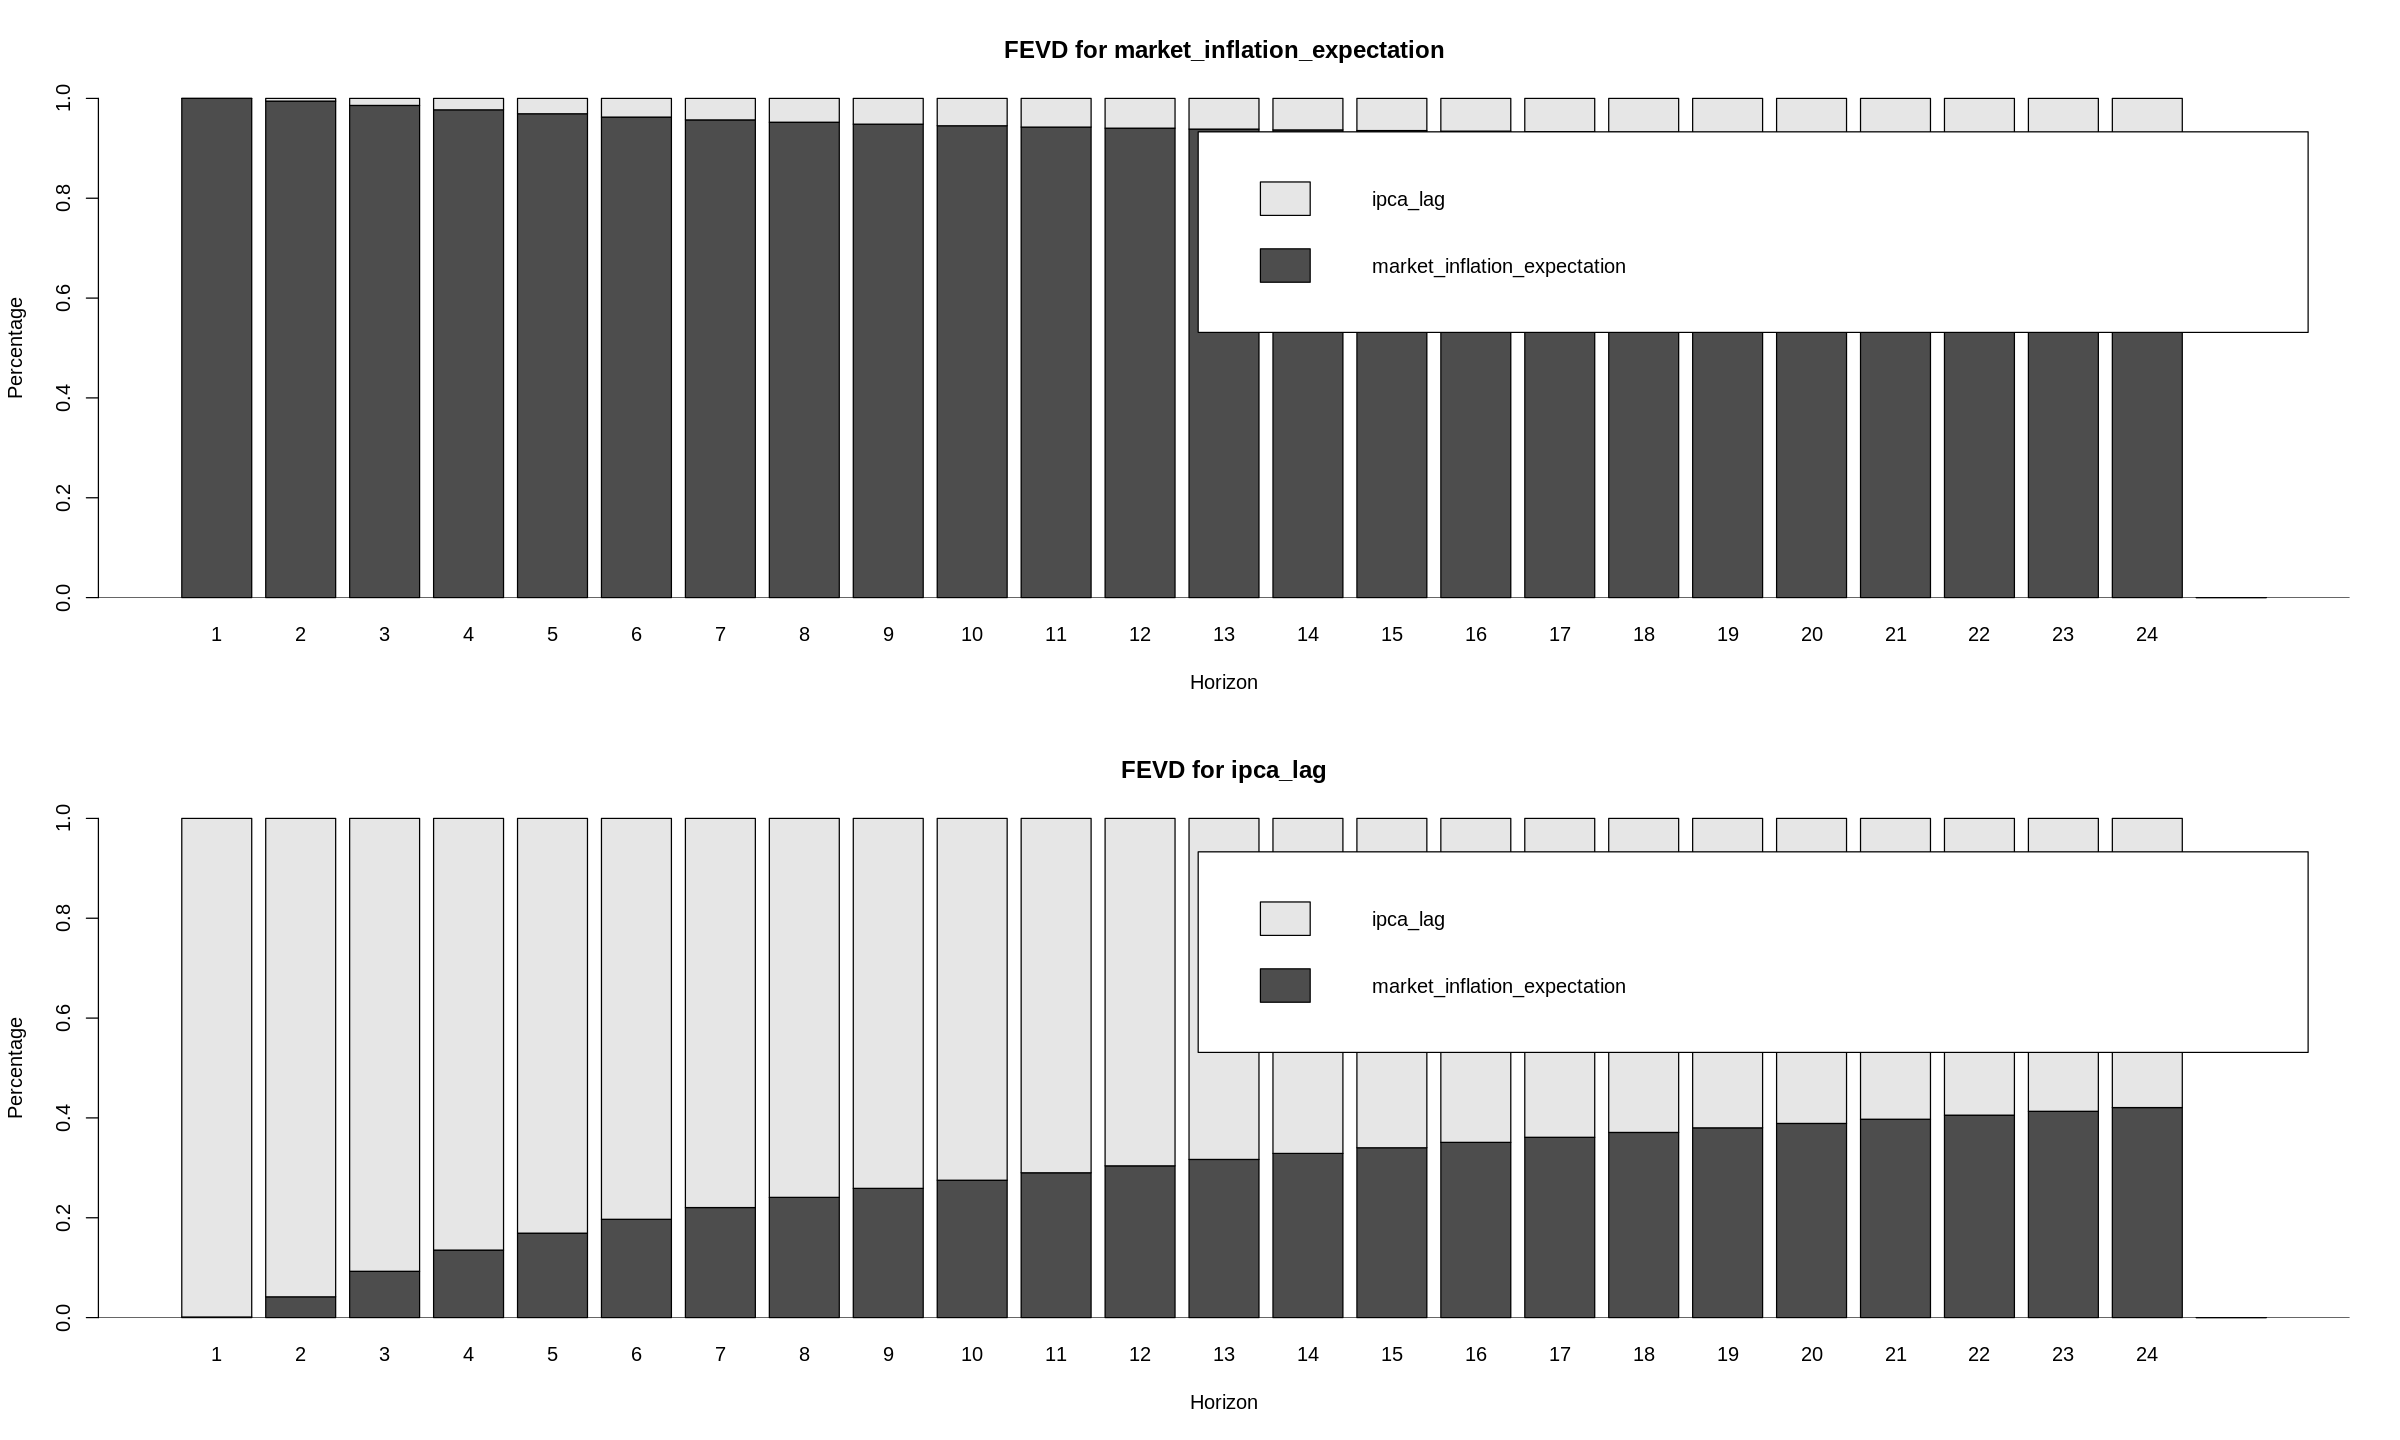

In [16]:
# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

plot(fevd_model)

**Resultado**

-

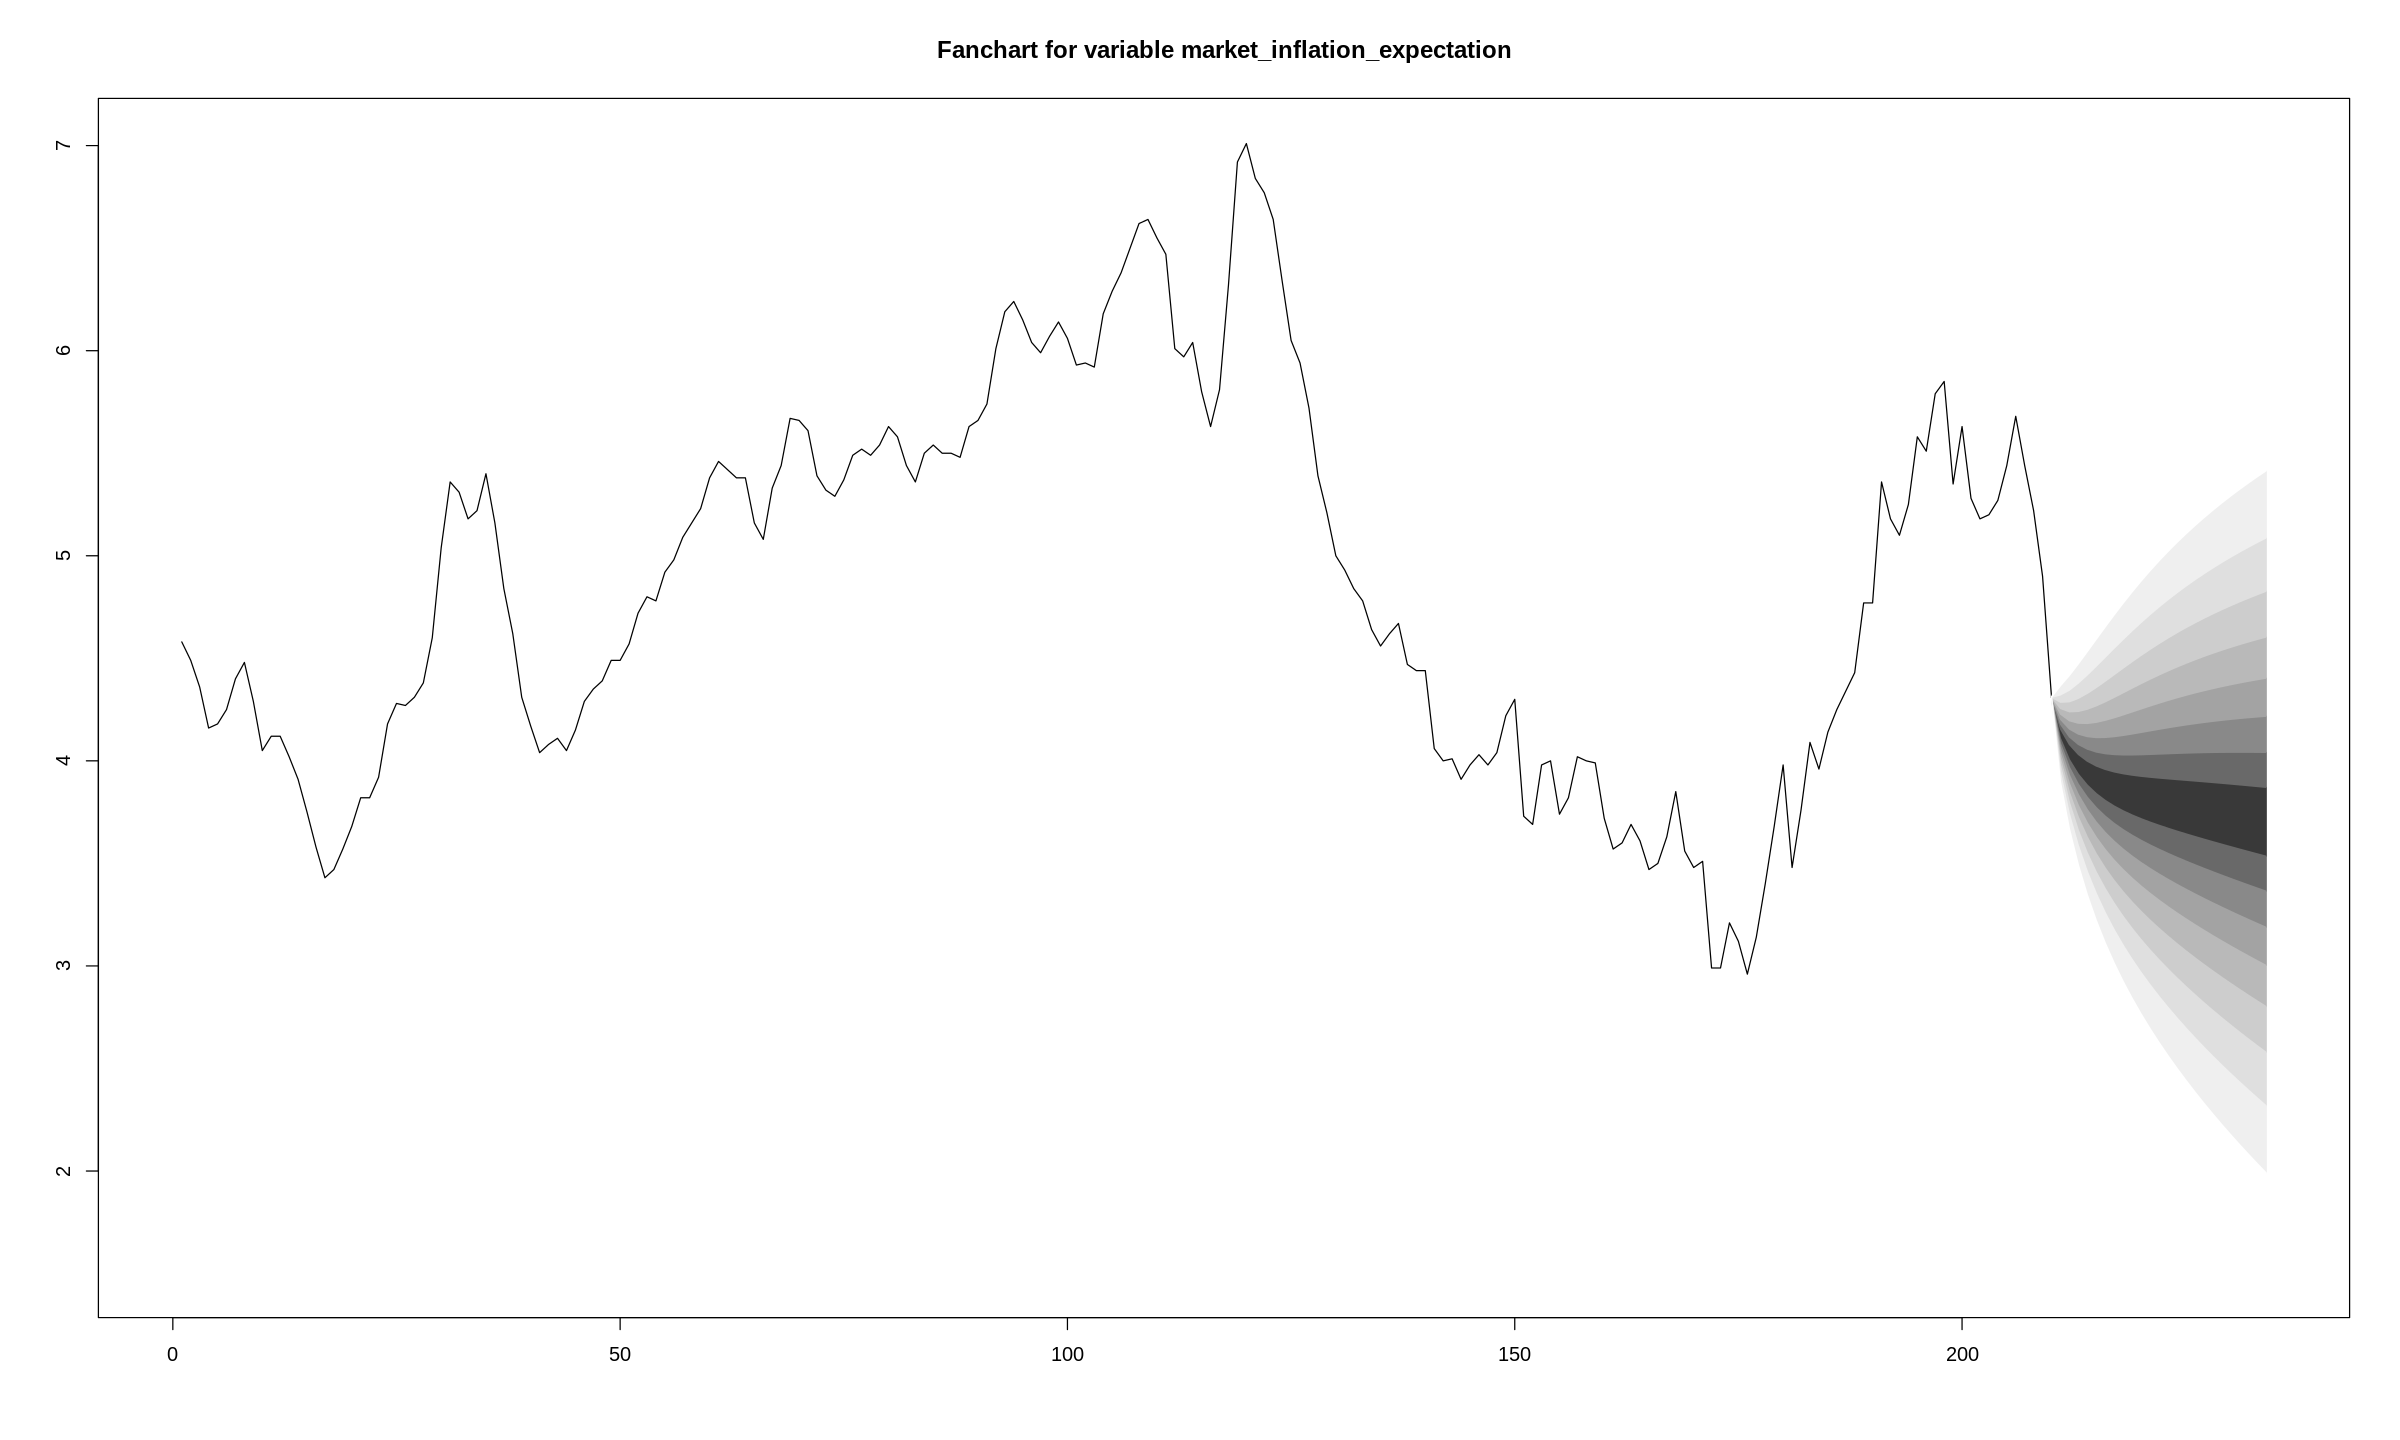

In [17]:
# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

fanchart(forecast_var, names = "market_inflation_expectation")

### **Modelo VECM**

In [18]:
# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca_lag", "selic_deflated_lag")]

In [19]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "none")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      5      2      5 


In [20]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "none", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.10739496 0.04819080 0.03159757

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  6.68  6.50  8.18 11.65
r <= 1 | 16.95 15.66 17.95 23.52
r = 0  | 40.58 28.71 31.52 37.22

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                market_inflation_expectation.l2 ipca_lag.l2
market_inflation_expectation.l2                      1.00000000   1.0000000
ipca_lag.l2                                         -1.64907352  -0.5653804
selic_deflated_lag.l2                                0.06290174  -0.8593892
                                selic_deflated_lag.l2
market_inflation_expectation.l2            1.00000000
ipca_lag.l2                               -0.20853595
selic_deflated_lag.l2                     -0.03090797

Weights W:
(This is the lo

**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 1 relação de cointegração no sistema

In [21]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "none", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.10739496 0.04819080 0.03159757

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 2 |  6.68  6.50  8.18 11.65
r <= 1 | 10.27 12.91 14.90 19.19
r = 0  | 23.63 18.90 21.07 25.75

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                market_inflation_expectation.l2 ipca_lag.l2
market_inflation_expectation.l2                      1.00000000   1.0000000
ipca_lag.l2                                         -1.64907352  -0.5653804
selic_deflated_lag.l2                                0.06290174  -0.8593892
                                selic_deflated_lag.l2
market_inflation_expectation.l2            1.00000000
ipca_lag.l2                               -0.20853595
selic_deflated_lag.l2                     -0.03090797



**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 5%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 5%, não se rejeita a hipótese nula, ou seja, existe no máximo 1 relação de cointegração no sistema

In [22]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 2, r = 1, estim = ("ML"))

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 210 	End sample size: 207
Number of variables: 3 	Number of estimated slope parameters 24
AIC -1835.053 	BIC -1748.402 	SSR 58.06398
Cointegrating vector (estimated by ML):
   market_inflation_expectation  ipca_lag selic_deflated_lag
r1                            1 -1.293334         -0.2681809


                                      ECT                Intercept         
Equation market_inflation_expectation 0.0078(0.0070)     0.0299(0.0289)    
Equation ipca_lag                     0.0603(0.0130)***  0.2185(0.0535)*** 
Equation selic_deflated_lag           -0.0575(0.0150)*** -0.2087(0.0616)***
                                      market_inflation_expectation -1
Equation market_inflation_expectation 0.2740(0.0718)***              
Equation ipca_lag                     0.6692(0.1329)***              
Equation selic_deflated_lag           -0.4133(0.1530)**              
                                      ipca_lag -1         

In [23]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 1)

In [24]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 232.28, df = 93, p-value = 6.639e-14



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 232.28, df = 93, p-value = 6.639e-14



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [25]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 593.28, df = 432, p-value = 3.815e-07



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 593.28, df = 432, p-value = 3.815e-07



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que o modelo não possui heteroscedasticidade

In [26]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 96.326, df = 6, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 6.1217, df = 3, p-value = 0.1058


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 90.205, df = 3, p-value < 2.2e-16




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 96.326, df = 6, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 6.1217, df = 3, p-value = 0.1058


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 90.205, df = 3, p-value < 2.2e-16




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

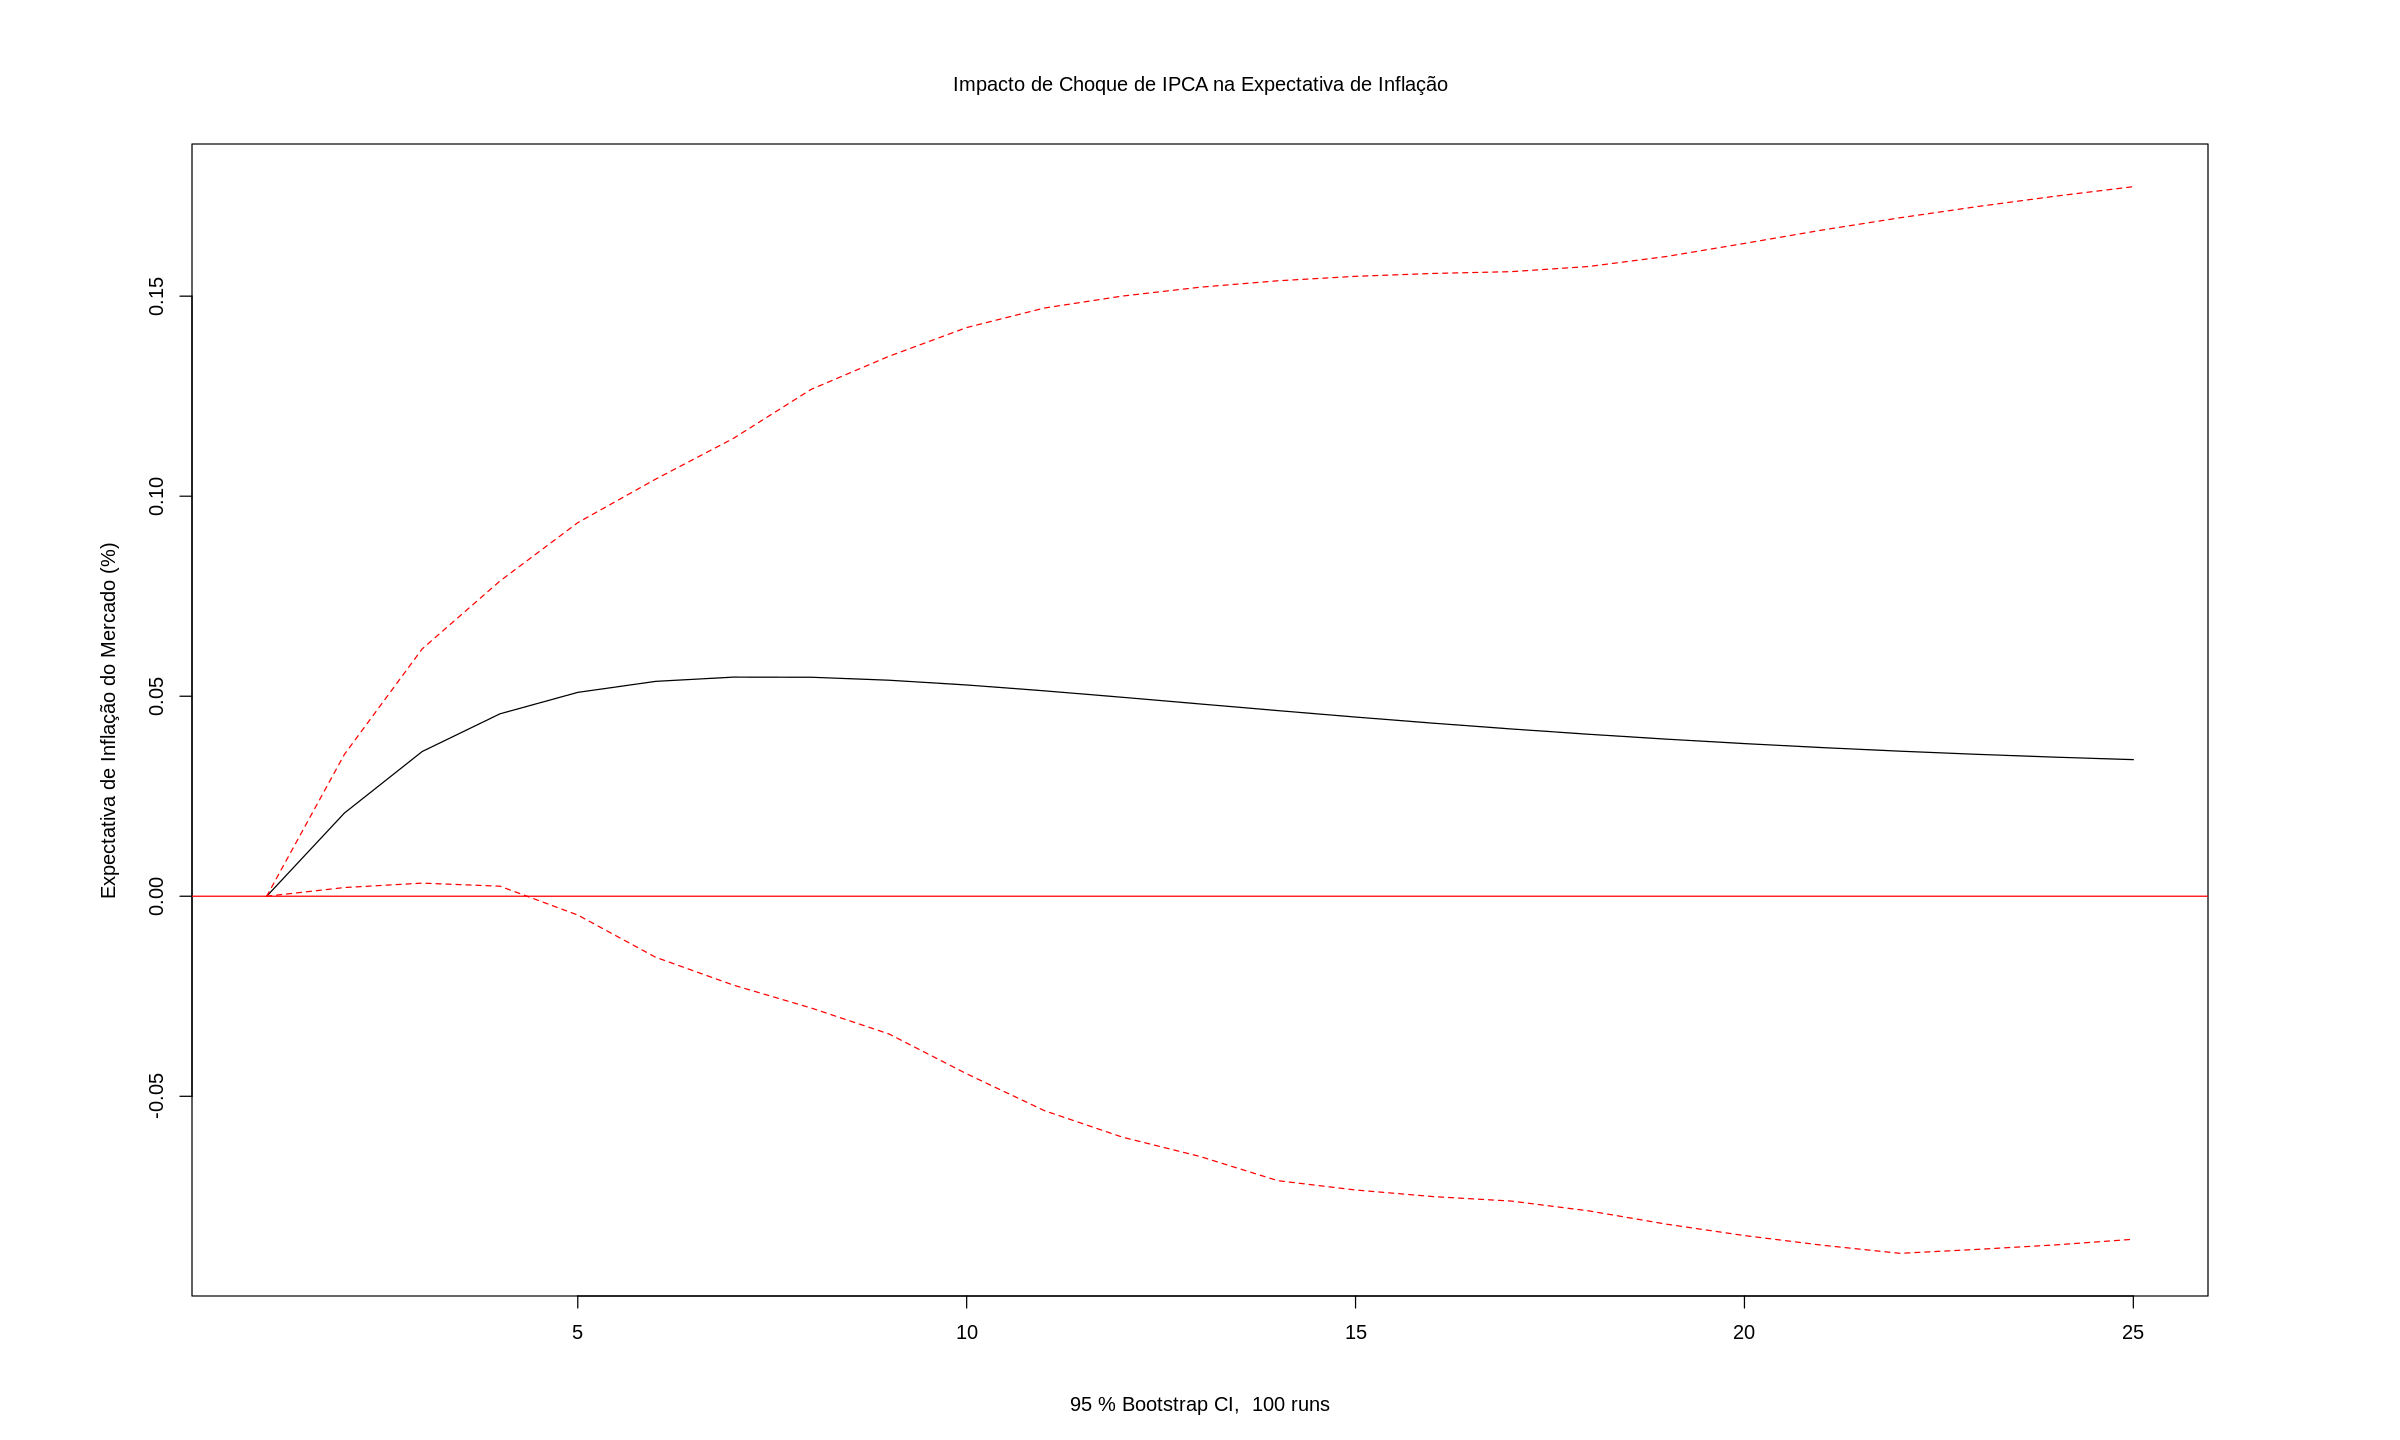

In [27]:
# Impulse Response Function
vecm_ipca_market_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca_lag", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_ipca_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "Impacto de Choque de IPCA na Expectativa de Inflação")

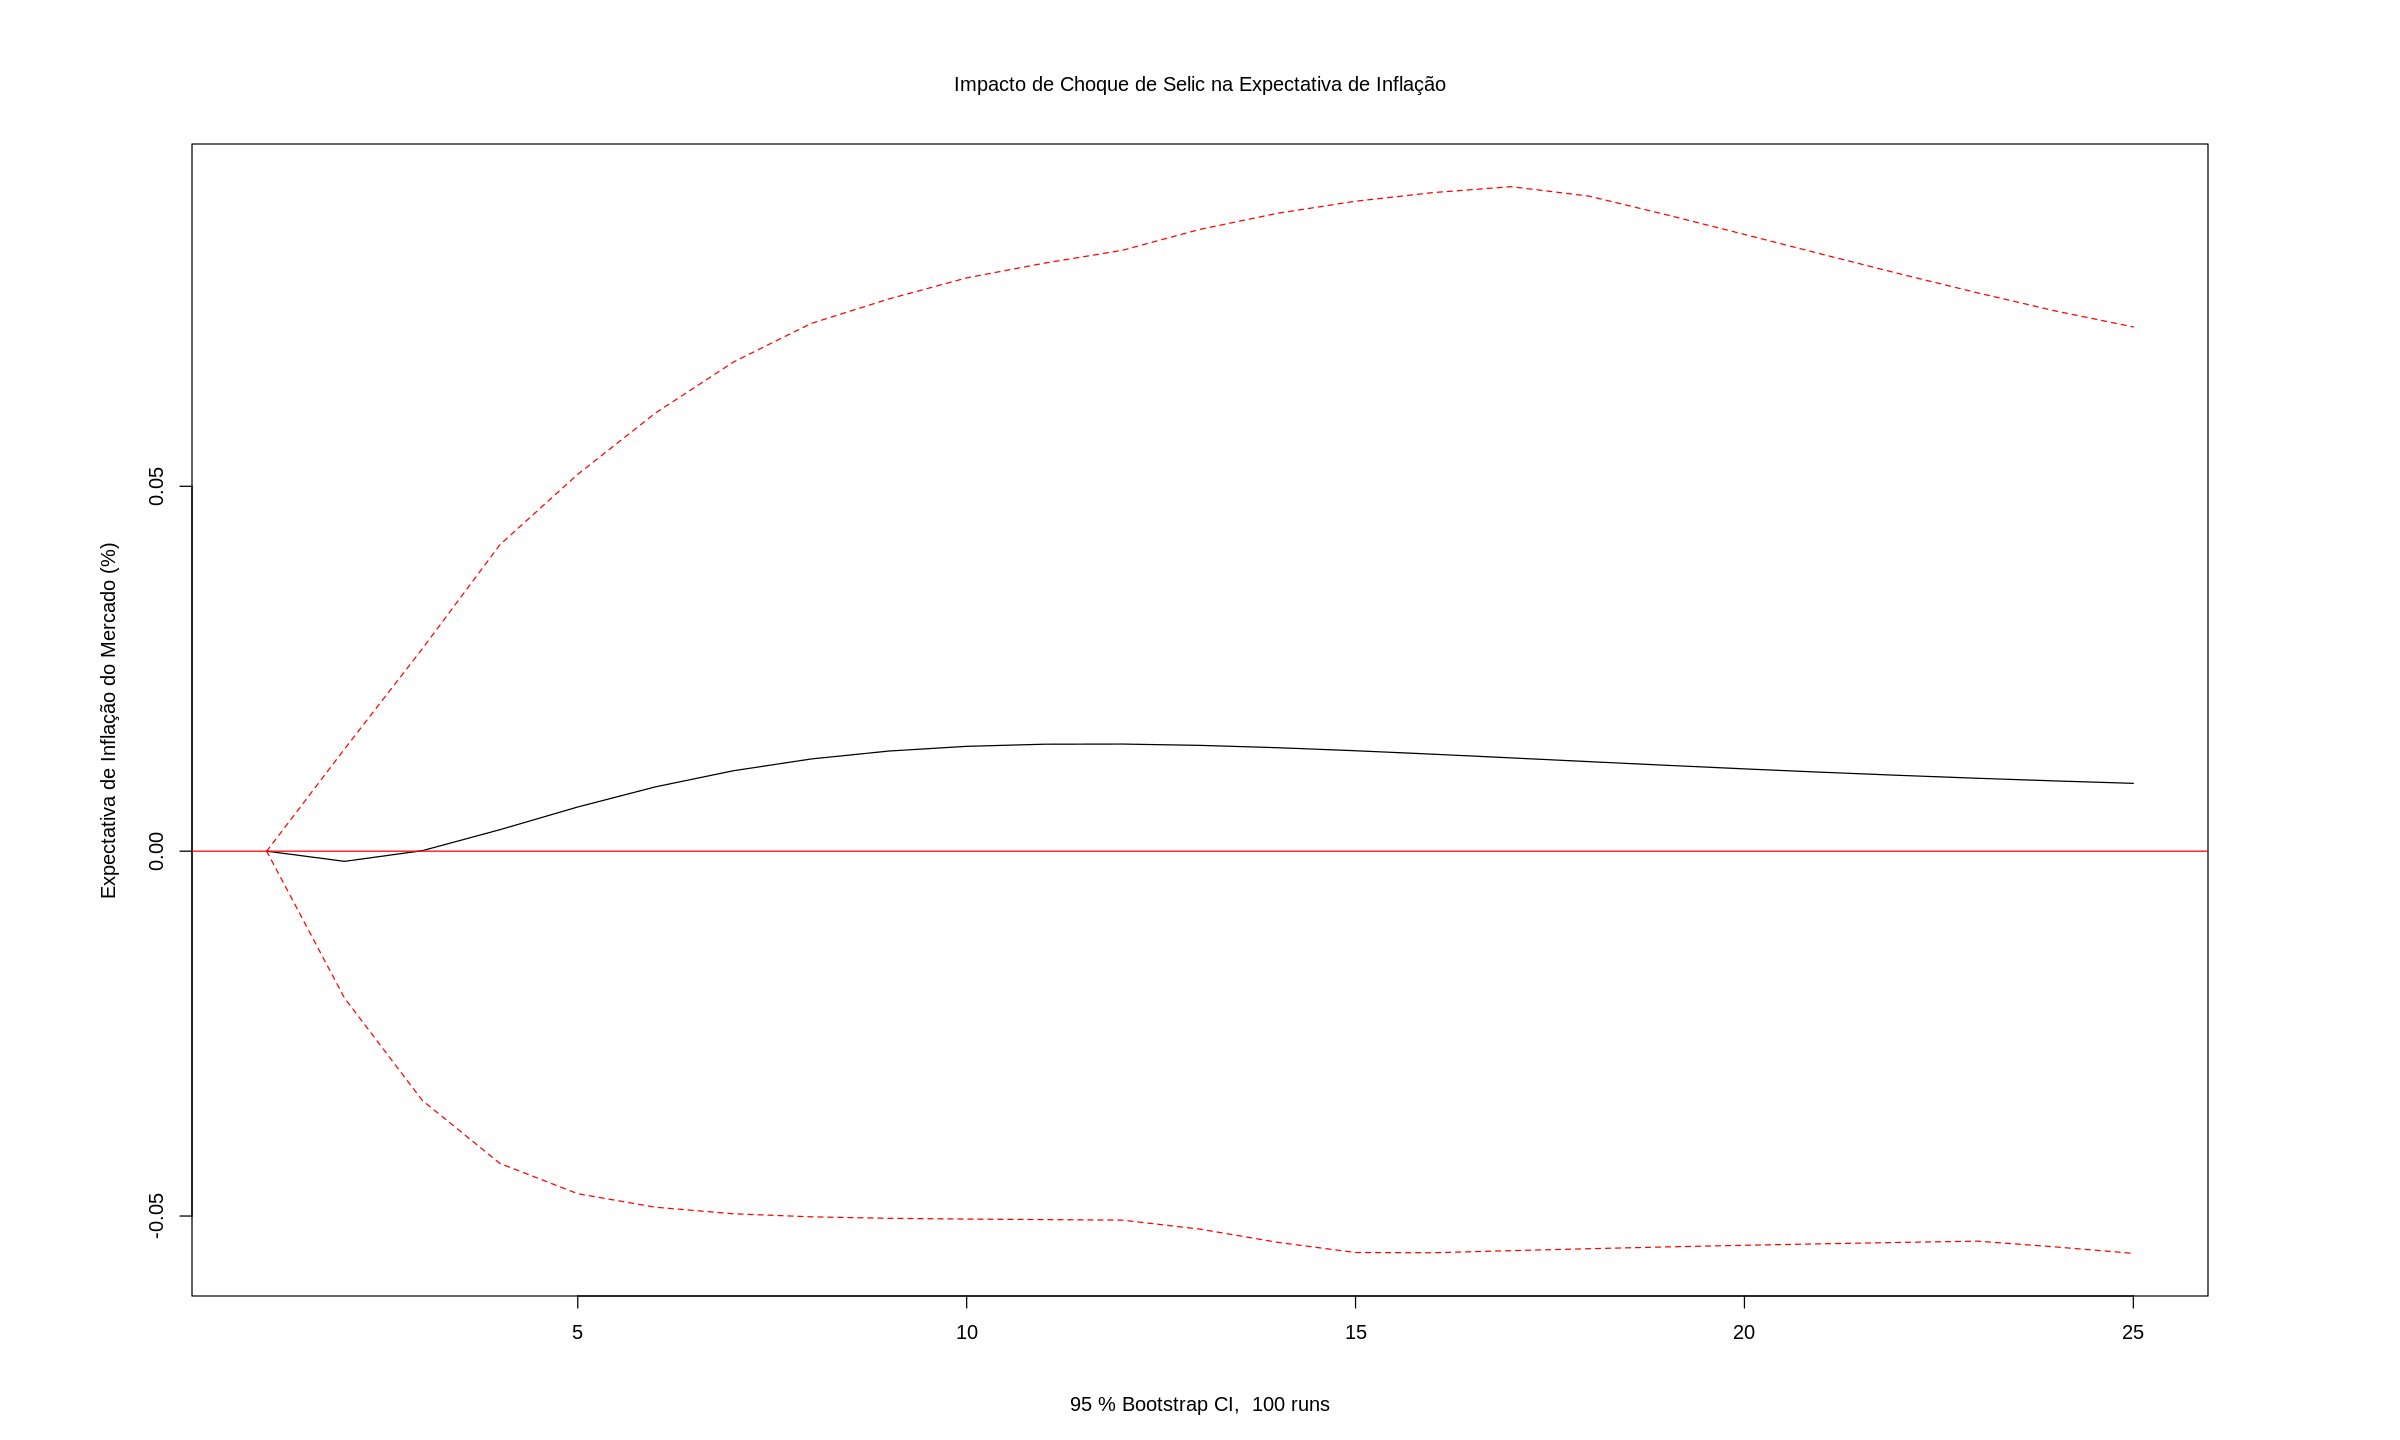

In [28]:
# Impulse Response Function
vecm_selic_market_expectation_impulse = irf(vecm_model_formatted, impulse = "selic_deflated_lag", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_selic_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "Impacto de Choque de Selic na Expectativa de Inflação")

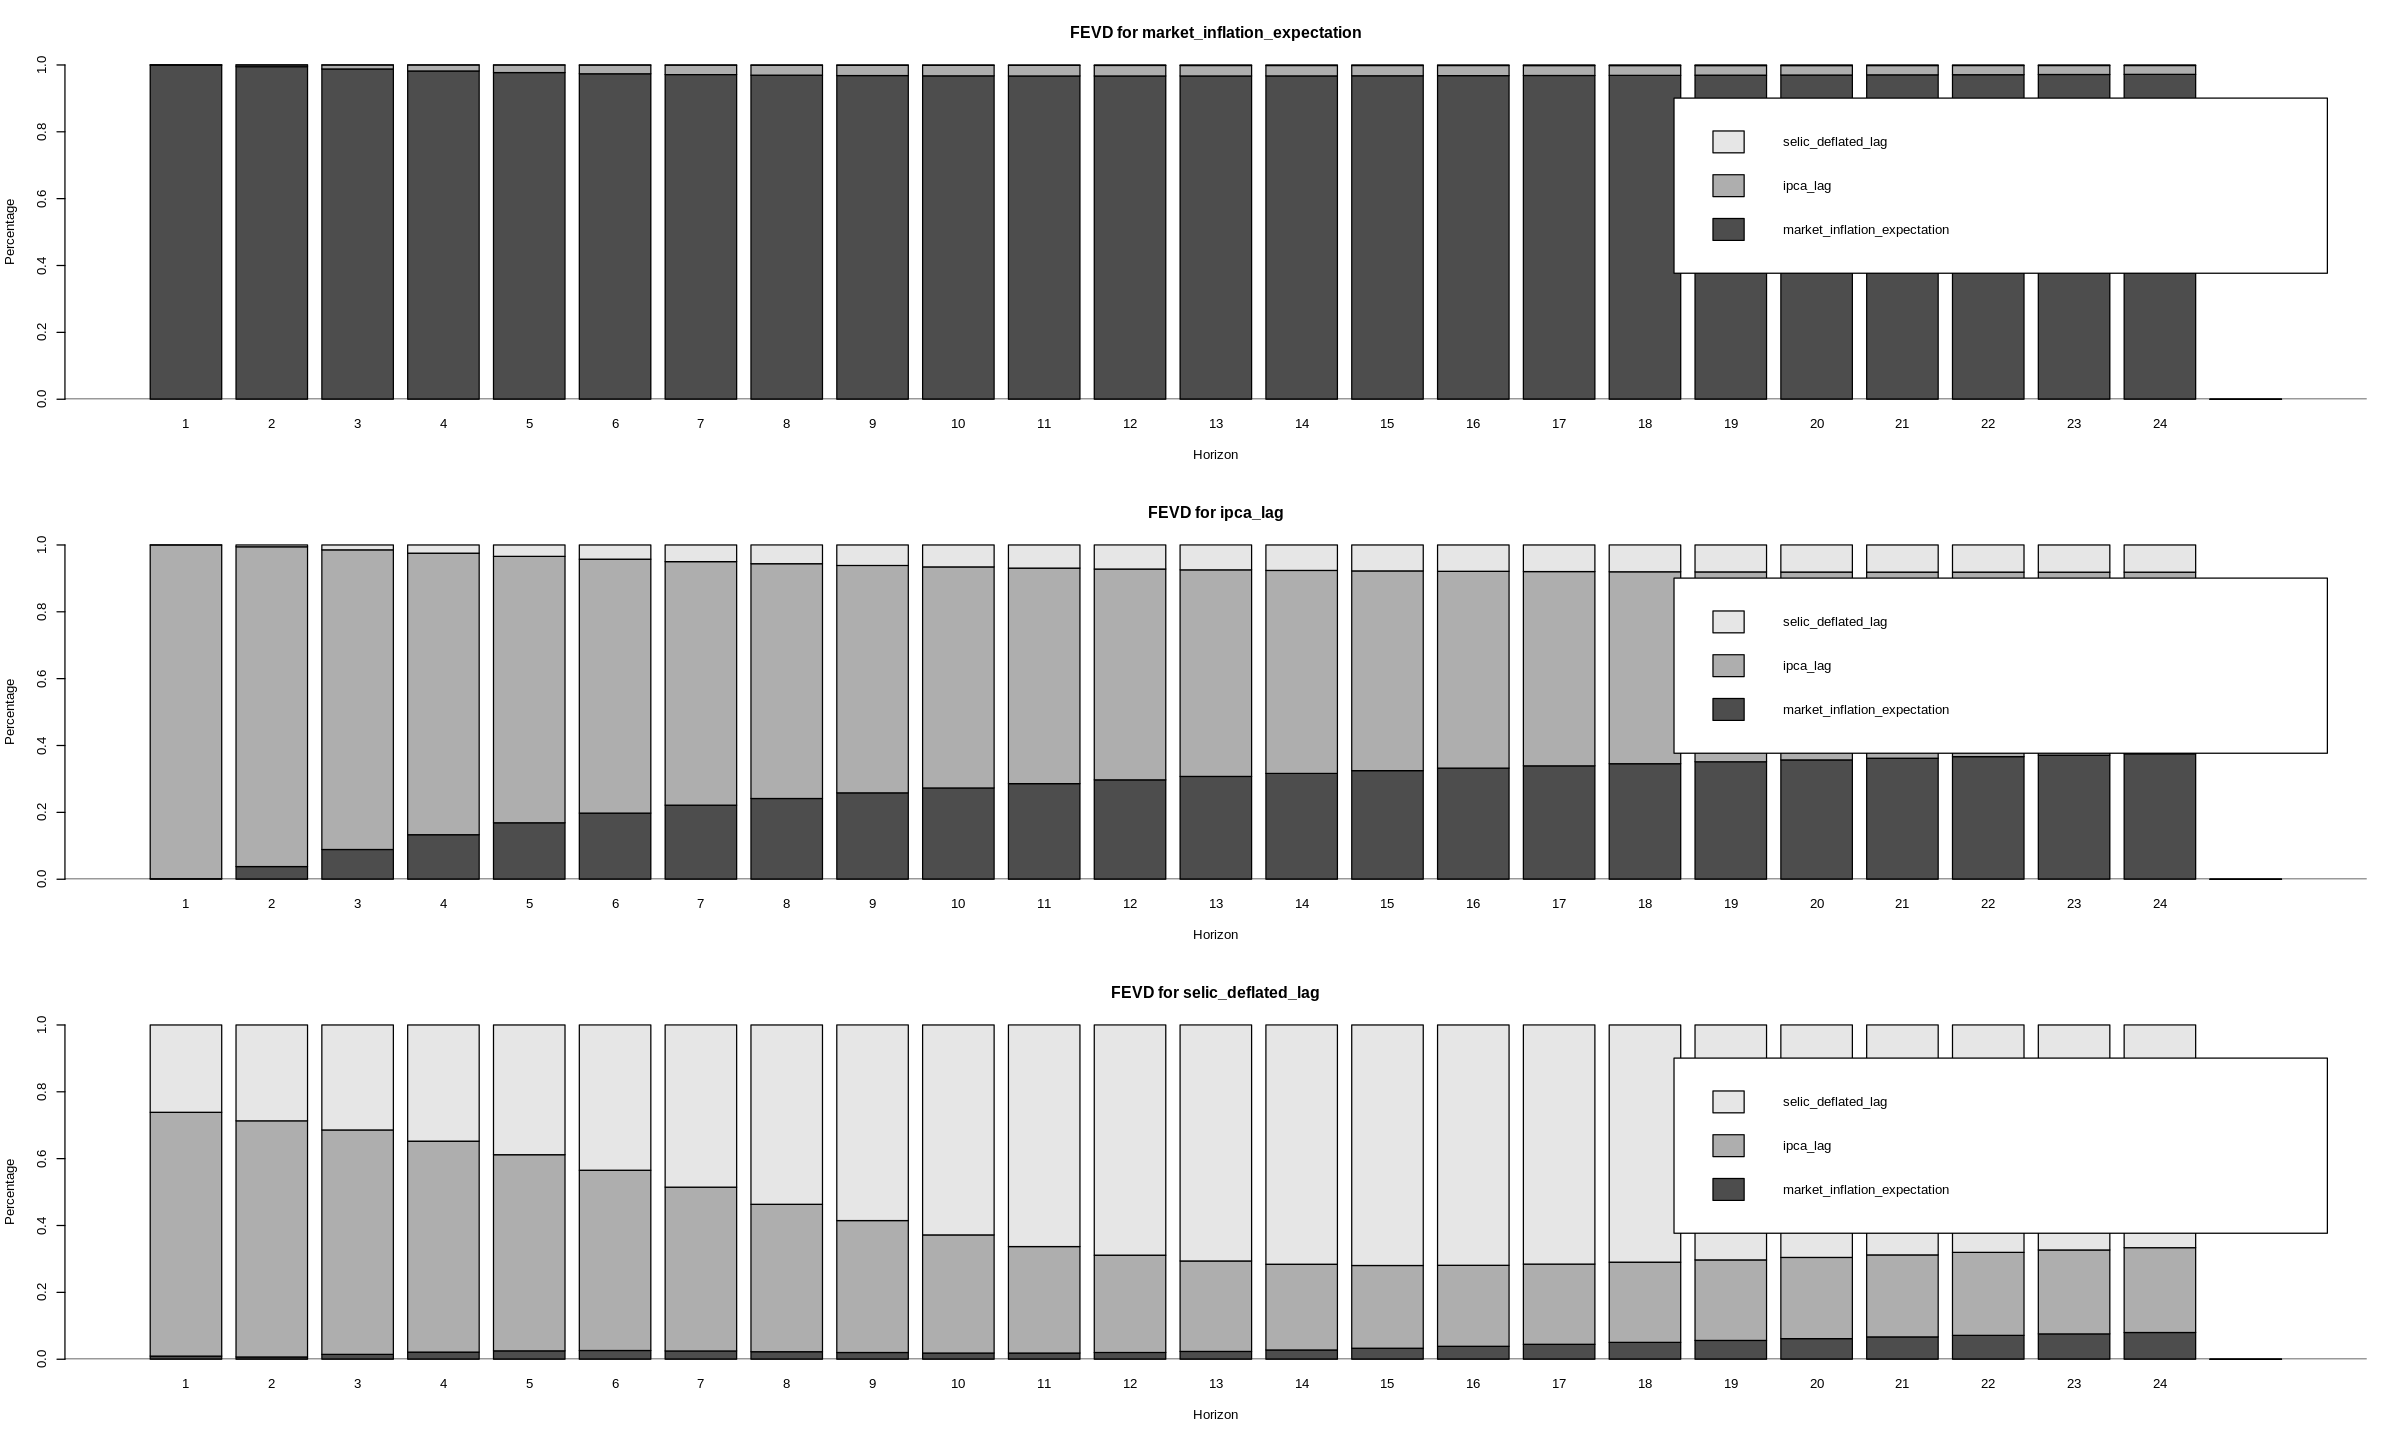

In [29]:
# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

plot(vecm_fevd)

**Resultado**

-

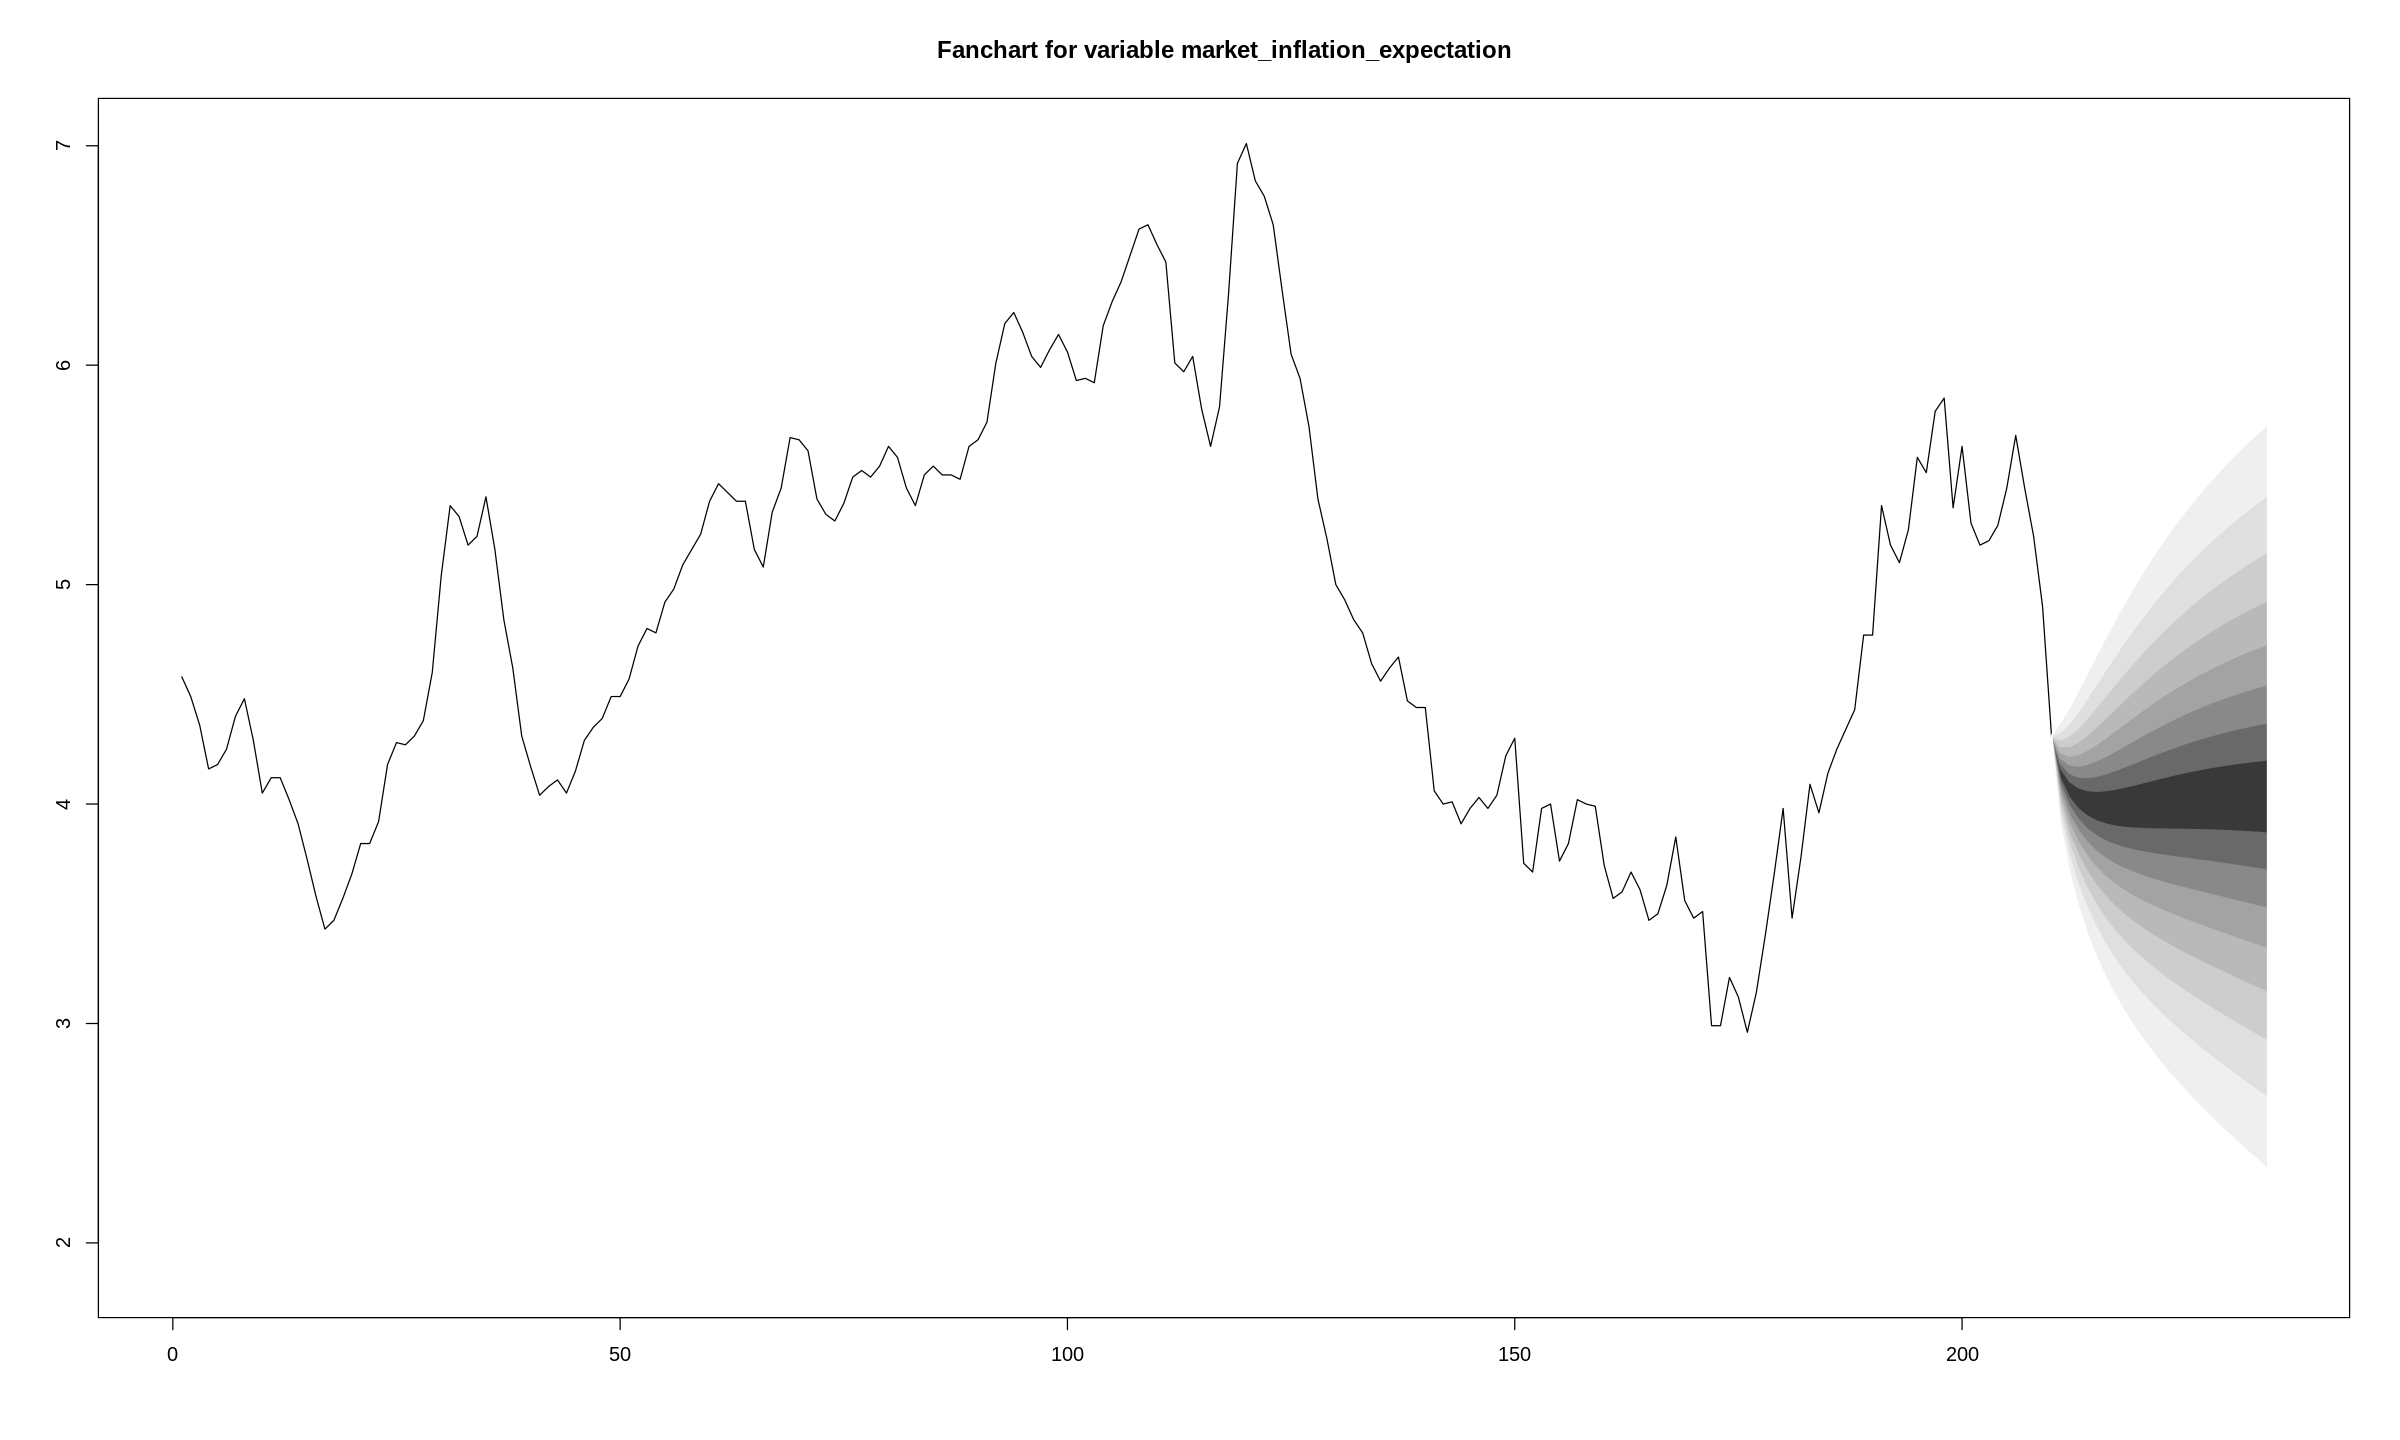

In [30]:
# Forecast using VECM
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

fanchart(forecast_vecm, names = "market_inflation_expectation")